<a href="https://colab.research.google.com/github/sraeisi/MachineLearning_Physics/blob/master/Lec_3/Model_Selection_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pre
====

In [0]:
# %load https://raw.githubusercontent.com/sraeisi/MachineLearning_Physics/master/pre.py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# from google.colab import files
import io, requests, zipfile



'''Set the defaults for your plots.'''
# plt.rcParams.update({'font.size': 20, 'figsize':(8,6)})
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 18

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rc('axes', linewidth = 5 )
plt.rc('lines', linewidth = 5 )

plt.rc('lines', markersize = 5 )

plt.rc('figure', figsize=(8,4) )         # Image size

from zipfile import ZipFile


from collections import Counter

import warnings
warnings.filterwarnings('ignore')

from sklearn.utils import shuffle

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, SGDClassifier
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures , StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error  ## To calculate the loss
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import learning_curve, validation_curve

In [0]:
'''
Let's plot these classifiers and see how well the decision boundaries are.
The following function is borrowed from the sklean guides. 
'''
def plot_contours(ax, clf, xx, yy, thrshld=0, **params):
    """Plot the decision boundaries for a classifier.
    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]) + thrshld
    Z = Z.reshape(xx.shape)
    ax.contour(xx, yy, Z,  levels=[-.5, 0, .5], linestyles=['--', '-', '--'])
    out = ax.contourf(xx, yy, Z,   **params)
    return out

def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in
    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional
    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max , h), np.arange(y_min, y_max , h) )
   
    return xx, yy

# Classification Metrics

For this section we are going to again use the particle identification data from 


https://www.kaggle.com/naharrison/particle-identification-from-detector-responses/home

We start with the binary classification and then get to the multi class case. 

## Binary Classification

In [3]:
## First load the data from the following url
url = 'https://www.dropbox.com/s/66dbhxl93y41coe/particle-identification-from-detector-responses.zip?dl=1'
s=requests.get(url, stream=True).content
data=pd.read_csv(io.BytesIO(s) , compression='zip' )
 
'''
Alternatively, you can download the file into your computer and run the following code. 
You need to uncomment it first. 
'''    

# data = pd.read_csv('particle-identification-from-detector-responses.zip', compression='zip')
data.head()

,id,p,theta,beta,nphe,ein,eout
0,211,0.780041,1.081480,0.989962,0,0.000000,0.000000
1,211,0.260929,0.778892,0.902450,0,0.000000,0.000000
2,2212,0.773022,0.185953,0.642428,4,0.101900,0.000000
3,211,0.476997,0.445561,0.951471,0,0.000000,0.000000
4,2212,2.123290,0.337332,0.908652,0,0.034379,0.049256


In [4]:
## Targets
targets = list(set(data['id']))
print(targets)
target_freq = Counter(data['id'])


features =  data.columns 
print(features)


[321, 211, 2212, -11]
Index(['id', 'p', 'theta', 'beta', 'nphe', 'ein', 'eout'], dtype='object')


In [5]:
## We only keep two features, this is for simplicity and also for visulaization purposes. 
features_2d = features[[0,1,3]]


## To speed things up in the class we take a small sample of the data

n_s = 10000  ## number of samples we keep. 

mini_data = data[features_2d].sample(n_s, axis=0, random_state=0)

mini_data['target'] = mini_data['id'].apply(lambda x: targets.index(x)) ## We add a label/target/class col which is the index of the id in the list of ids.

mini_data.drop('id',axis=1, inplace=True)
mini_data.head()


,p,beta,target
3748577,1.230330,0.985857,1
4555504,0.870680,0.989180,1
2388454,1.320670,0.806984,2
3738046,0.657969,0.982778,1
1572731,1.756310,0.993275,1


##Binary Classification

In [6]:
print('The classes and corresponding frequencies are: \n {}'.format(Counter(data['id']) )) 

The classes and corresponding frequencies are: 
 Counter({211: 2806833, 2212: 1945849, 321: 232471, -11: 14847})


In [7]:
## We only keep the following two targets
## We intentionally pick two classes with the largest bias. 
ind_1 = 0
ind_2 =  1
print('The ration of the number of the samples of the two classes are {}'.format( target_freq[targets[ind_1]]/target_freq[targets[ind_2]] ) )


## Only keep the part of the data with one of the two target classes. 
bmd = mini_data[ (mini_data['target']==ind_1) | (mini_data['target']==ind_2) ].copy()


X = bmd.drop('target', axis=1)
Y = bmd['target']

X_train, X_test, Y_train, Y_test = train_test_split(bmd.drop('target', axis=1)  , bmd['target'], random_state = 0 )

The ration of the number of the samples of the two classes are 0.08282323886030982


In [8]:
print('Our train set has: {}'.format(  Counter(Y_train) ))
print('Our test set has: {}'.format(  Counter(Y_test) ))
print('And in total, the whole set has: {}'.format(  Counter(mini_data['target']) ))

Our train set has: Counter({1: 4211, 0: 330})
Our test set has: Counter({1: 1403, 0: 111})
And in total, the whole set has: Counter({1: 5614, 2: 3909, 0: 441, 3: 36})


In [9]:
## Let's try a dummy classifier that constantly outputs the more probable class.
from sklearn.dummy import DummyClassifier



dm_clf = DummyClassifier(strategy='most_frequent')
dm_clf.fit(X_train, Y_train)
print('The dummy classifier can give a score of {} on the test data.'.format(dm_clf.score(X_test,Y_test)))

The dummy classifier can give a score of 0.9266842800528402 on the test data.


This indicates that even a ignorant classifier can achieve a high score for this task, where it is totally ignoring one of the classes. 

How should we deal with this?

We need to ask what we really care about? Is the accuracy the right metric for this problem?

Alternatives
**Precision**: The fraction of items in class 3 that we got right. 
**Recall**: The fraction of guesses each that were correct

For this we need to go back to basic statistics and see what could happen in a classification problem like this. Here's a famous picture that you probably have seen before:


| TP || FP   |
|------||------|
|   FN  || TP|

Here follow the same ideas and use different metrics for evalution of our models.


In [10]:
%%time

from sklearn.model_selection import cross_val_score, cross_validate

clf = SVC()
scores = cross_val_score(clf, bmd.drop('target', axis=1)  , bmd['target'], cv=10, n_jobs=-1)
print(pd.DataFrame(scores))


          0
0  0.929160
1  0.927393
2  0.929043
3  0.927393
4  0.935537
5  0.925620
6  0.928926
7  0.928926
8  0.930579
9  0.933884
CPU times: user 80.8 ms, sys: 56.5 ms, total: 137 ms
Wall time: 3.53 s


In [0]:
clf.fit(X_train, Y_train)
predicted_Y = clf.predict( X )

In [12]:
from sklearn.metrics import confusion_matrix
cnfmatrix = confusion_matrix(bmd['target'],predicted_Y)
print(cnfmatrix)
## Do this for the dummy classifier and guess what it should return. 

[[  24  417]
 [  19 5595]]


In [13]:
## Metric for findig the right model
## The right metric/loss depends on the specifics of the question and what our objective is. 
## One common solution is to take a combination of the precision and recall, called f_score
## Which is defined as a (1+beta)(precision*recall)/(beta*precision+recall).
## For beta=1, we get the famous f1 score. For beta = 0  and inf what does it go to?
## We often use the report in sklearn to get all of these values. 

from sklearn.metrics import classification_report
clf_report = classification_report(bmd['target'], predicted_Y)
print(clf_report)

              precision    recall  f1-score   support

           0       0.56      0.05      0.10       441
           1       0.93      1.00      0.96      5614

   micro avg       0.93      0.93      0.93      6055
   macro avg       0.74      0.53      0.53      6055
weighted avg       0.90      0.93      0.90      6055



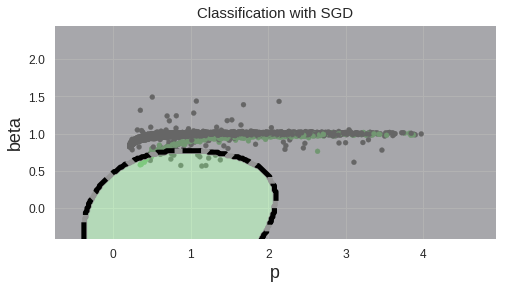

In [36]:
x_label = features_2d[1]
y_label = features_2d[2]

X0, X1 = X[x_label], X[y_label]
xx, yy = make_meshgrid(X0, X1)

plt_title = 'Classification with SGD'
fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
ax.scatter(X_train[x_label],X_train[y_label], c=Y_train, cmap=plt.cm.Accent)
plot_contours(ax, clf, xx, yy, cmap=plt.cm.Accent, alpha=0.5)

plt.show()

In [34]:
%%time
from scipy.stats import expon
params_dist = {'C': expon(scale=10), 'gamma':expon(scale=10)}

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, make_scorer
pos_label = 0
scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'precision':make_scorer(precision_score, pos_label=pos_label)
           , 'recall':make_scorer(recall_score, pos_label=pos_label), 'f1':make_scorer(f1_score, pos_label=pos_label)}

opt_clf = RandomizedSearchCV(clf, param_distributions=params_dist, cv=5, n_jobs=-1, refit='Accuracy', scoring=scoring)
opt_clf.fit(X_train,Y_train)

CPU times: user 462 ms, sys: 15.4 ms, total: 477 ms
Wall time: 16.9 s


In [35]:
result = pd.DataFrame(opt_clf.cv_results_)
result

,mean_fit_time,mean_score_time,mean_test_AUC,mean_test_Accuracy,mean_test_f1,mean_test_precision,mean_test_recall,mean_train_AUC,mean_train_Accuracy,mean_train_f1,...,std_test_AUC,std_test_Accuracy,std_test_f1,std_test_precision,std_test_recall,std_train_AUC,std_train_Accuracy,std_train_f1,std_train_precision,std_train_recall
0,0.135382,0.126269,0.938221,0.927329,0.000000,0.000000,0.000000,0.939289,0.927329,0.000000,...,0.008608,0.000032,0.000000,0.000000,0.000000,0.004708,0.000008,0.000000,0.000000,0.000000
1,0.168874,0.111474,0.969665,0.938340,0.390149,0.719553,0.278817,0.972914,0.940927,0.415350,...,0.010157,0.004736,0.075107,0.126118,0.079383,0.001198,0.003044,0.050244,0.022721,0.046169
2,0.173230,0.093321,0.975763,0.964545,0.726770,0.834232,0.651512,0.982118,0.966803,0.745588,...,0.005512,0.005538,0.042943,0.083971,0.064276,0.001214,0.001260,0.011052,0.015414,0.017991
3,0.172030,0.089208,0.974666,0.964545,0.734928,0.814874,0.675756,0.983678,0.969335,0.768783,...,0.005903,0.006039,0.040284,0.084914,0.053003,0.001060,0.001562,0.011771,0.013475,0.011082
4,0.166979,0.109627,0.971442,0.954856,0.613484,0.818533,0.496964,0.976700,0.955517,0.617077,...,0.008080,0.005245,0.052570,0.083855,0.065269,0.001095,0.001373,0.010755,0.020710,0.009091
5,0.170326,0.094622,0.975202,0.964325,0.723030,0.835848,0.645446,0.981763,0.966692,0.744524,...,0.005294,0.005800,0.048573,0.082810,0.073350,0.001232,0.001302,0.011464,0.013892,0.017863
6,0.171783,0.096899,0.972691,0.964105,0.722133,0.834553,0.642420,0.979834,0.966803,0.743644,...,0.005536,0.005230,0.037639,0.083445,0.052131,0.001682,0.001037,0.009400,0.015934,0.017441
7,0.159525,0.115416,0.969550,0.950672,0.562353,0.804669,0.439397,0.974756,0.950782,0.558871,...,0.008948,0.004250,0.043862,0.094136,0.058283,0.001027,0.002747,0.029278,0.028676,0.026849
8,0.160792,0.121492,0.968776,0.940982,0.420323,0.753208,0.300024,0.973672,0.943845,0.456777,...,0.009768,0.005056,0.069367,0.116341,0.072611,0.001391,0.002471,0.034028,0.028261,0.030773
9,0.166116,0.114574,0.969413,0.947368,0.526301,0.780411,0.406065,0.973631,0.947864,0.529628,...,0.010434,0.003054,0.035423,0.097638,0.057009,0.001146,0.003357,0.040461,0.029054,0.039438


In [36]:
opt_predicted_Y = opt_clf.predict(bmd.drop('target', axis=1))
print('The confusion matrix is: \n {}'.format(confusion_matrix(Y, opt_predicted_Y) ) )
print('The classification report is: \n {}'.format(classification_report(Y, opt_predicted_Y) ) )

The confusion matrix is: 
 [[ 291  150]
 [  49 5565]]
The classification report is: 
               precision    recall  f1-score   support

           0       0.86      0.66      0.75       441
           1       0.97      0.99      0.98      5614

   micro avg       0.97      0.97      0.97      6055
   macro avg       0.91      0.83      0.86      6055
weighted avg       0.97      0.97      0.97      6055



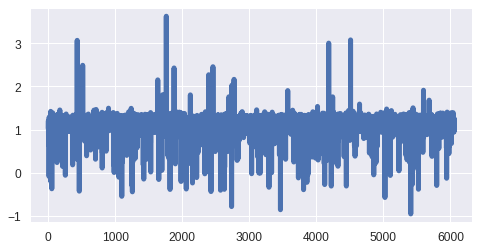

In [38]:
f_y = clf.decision_function(X)
plt.plot(f_y)
# plt.plot(predicted_Y)
plt.show()

In [38]:
'''
The following function defines and returns a new classifier based on the clf. 
It is assuming that the clf has a decision function. 
The output is a clf that instead of 0, the threshold for returning a class is 
set by thrshld. 
'''
def clf_with_thrshld(clf,thrshld=0):
  def new_clf(X):
    return (clf.decision_function(X)> thrshld)
  
  return new_clf


## test it
clf_with_thrshld(clf)(X)-predicted_Y

array([0, 0, 0, ..., 0, 0, 0])

The confusion matrix is: 
 [[  24  417]
 [  19 5595]]
The classification report is: 
               precision    recall  f1-score   support

           0       0.56      0.05      0.10       441
           1       0.93      1.00      0.96      5614

   micro avg       0.93      0.93      0.93      6055
   macro avg       0.74      0.53      0.53      6055
weighted avg       0.90      0.93      0.90      6055



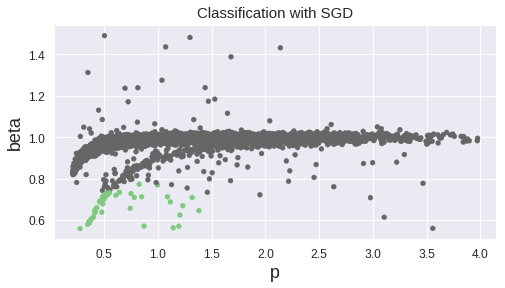

In [39]:
## Let's try to have clf higher recall

ts=0 ## Threshold for the classification

r_predicted_Y = clf_with_thrshld(clf,ts)(X)
print('The confusion matrix is: \n {}'.format(confusion_matrix(Y, r_predicted_Y) ) )
print('The classification report is: \n {}'.format(classification_report(Y, r_predicted_Y) ) )

fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
ax.scatter(X[x_label],X[y_label], c=r_predicted_Y, cmap=plt.cm.Accent)
# plot_contours(ax, clf, xx, yy, thrshld=ts, cmap=plt.cm.Accent, alpha=0.5)

plt.show()

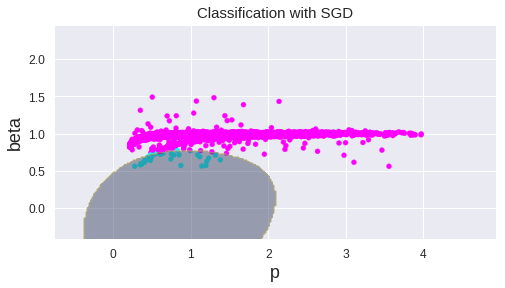

In [56]:
## Let's try to have clf higher recall

ts=0 ## Threshold for the classification

r_predicted_Y = clf_with_thrshld(clf,ts)(X)

Z = clf_with_thrshld(clf,ts)(np.c_[xx.ravel(), yy.ravel()]) 
Z = Z.reshape(xx.shape)


fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
ax.scatter(X[x_label],X[y_label], c=r_predicted_Y, cmap=plt.cm.cool)
ax.contourf(xx, yy, Z,  levels=[-.5, 0, .5], linestyles=['--', '-', '--'], cmap=plt.cm.cividis, alpha=0.5)


plt.show()

In [97]:
## Let's try to have a more precise clf
p_predicted_Y = clf_with_thrshld(clf,-1.85)(X)
print('The confusion matrix is: \n {}'.format(confusion_matrix(Y, p_predicted_Y) ) )
print('The classification report is: \n {}'.format(classification_report(Y, p_predicted_Y) ) )

The confusion matrix is: 
 [[  13  428]
 [  15 5599]]
The classification report is: 
               precision    recall  f1-score   support

           0       0.46      0.03      0.06       441
           1       0.93      1.00      0.96      5614

   micro avg       0.93      0.93      0.93      6055
   macro avg       0.70      0.51      0.51      6055
weighted avg       0.90      0.93      0.90      6055



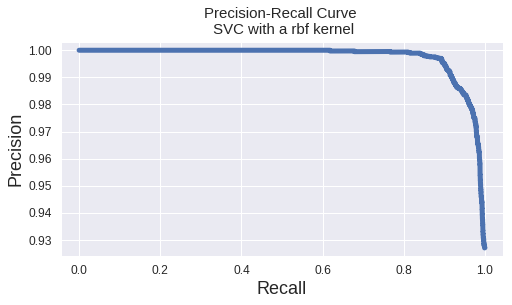

In [71]:
## Plot the precision-recall curve => Do it for SVC
from sklearn.metrics import precision_recall_curve

decision_values = clf.decision_function(X)

precision, recall, thresholds = precision_recall_curve(Y, decision_values)


plt_title = 'Precision-Recall Curve \n SVC with a rbf kernel'
x_label = 'Recall'
y_label = 'Precision'

fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)

plt.plot(recall, precision)
plt.show()

In [0]:
'''
Exercise: Redo this for a SGDclassifier
'''

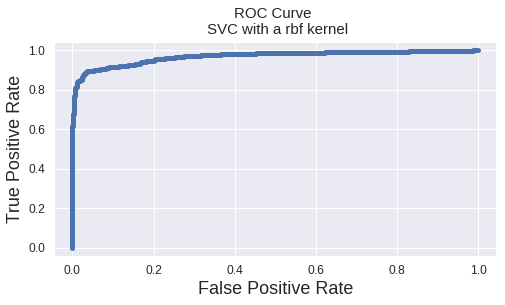

In [69]:
## AUC plot

from sklearn.metrics import roc_curve

fpr, tpr, thrsld_list = roc_curve(Y, decision_values)

plt_title = 'ROC Curve \n SVC with a rbf kernel'
x_label = 'False Positive Rate'
y_label = 'True Positive Rate'

fig = plt.figure()
ax = fig.add_subplot(111,xlabel=x_label, ylabel = y_label, title = plt_title)
plt.plot(fpr, tpr)
plt.show()

Multi-Class evalution
====

In [0]:
'''
For the data, we need to use the mini_data instead of bmd
'''

## Only keep the part of the data with one of the two target classes. 
bmd = mini_data[ (mini_data['target']==ind_1) | (mini_data['target']==ind_2) ].copy()


m_X =  mini_data.drop('target', axis=1)
m_Y =  mini_data['target']

m_X_train, m_X_test, m_Y_train, m_Y_test = train_test_split(m_X  , m_Y, random_state = 0 )

In [79]:
m_clf = SVC(gamma=10)
m_clf.fit(m_X_train, m_Y_train)

m_predicted_Y = m_clf.predict(m_X_test)

print('The confusion matrix is: \n {}'.format(pd.DataFrame(confusion_matrix(m_Y_test, m_predicted_Y)) ) )
print('The classification report is: \n {}'.format(classification_report(m_Y_test, m_predicted_Y) ) )

The confusion matrix is: 
     0     1    2  3
0  35    68    9  0
1   6  1388   25  0
2   1     5  948  0
3   0    15    0  0
The classification report is: 
               precision    recall  f1-score   support

           0       0.83      0.31      0.45       112
           1       0.94      0.98      0.96      1419
           2       0.97      0.99      0.98       954
           3       0.00      0.00      0.00        15

   micro avg       0.95      0.95      0.95      2500
   macro avg       0.68      0.57      0.60      2500
weighted avg       0.94      0.95      0.94      2500



In [92]:
m_decision_values = m_clf.decision_function(m_X).T
print(m_decision_values.shape )

(4, 10000)


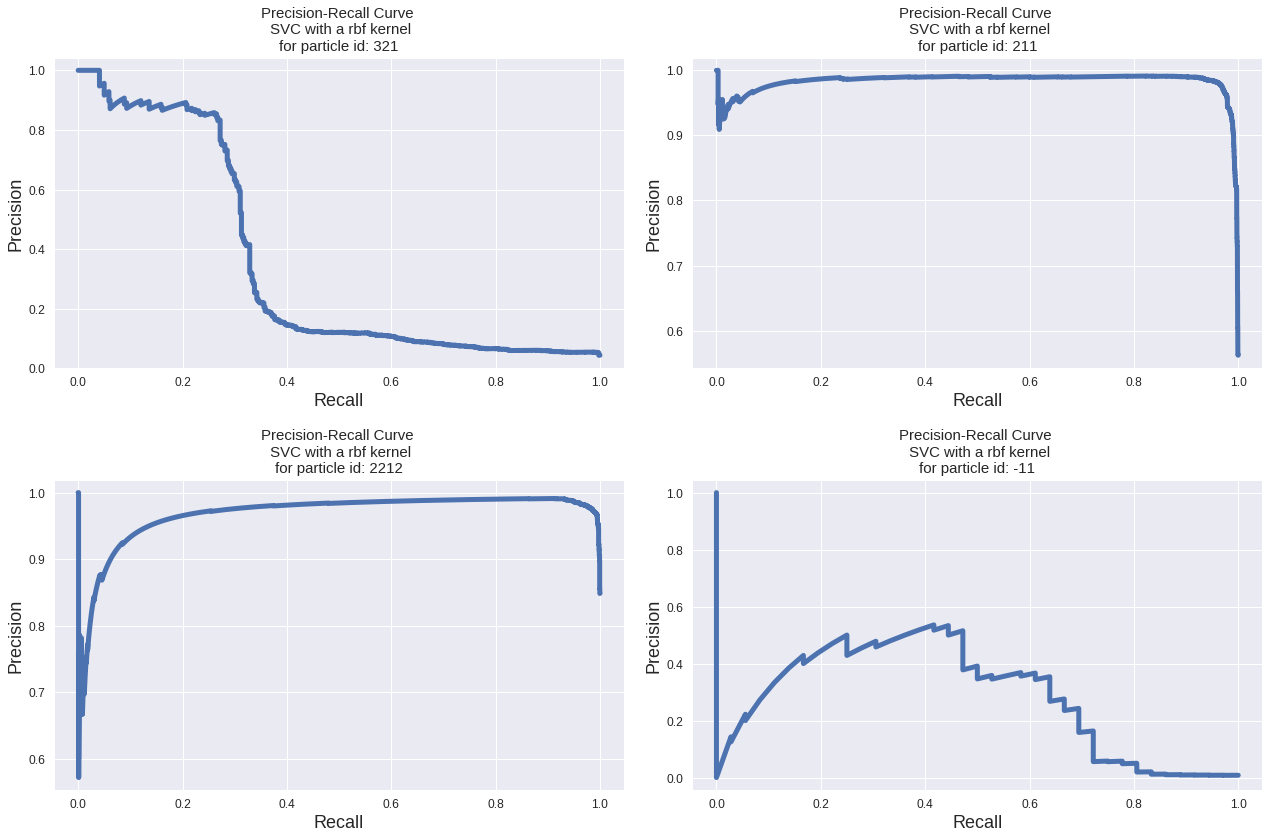

In [93]:
plt_title = 'Precision-Recall Curve \n SVC with a rbf kernel\n'
x_label = 'Recall'
y_label = 'Precision'

fig = plt.figure(figsize=(18,12))

for pos_label in [0,1,2,3]:
  precision, recall, thresholds = precision_recall_curve(m_Y, m_decision_values[pos_label], pos_label=pos_label )
  ax = fig.add_subplot(2,2,pos_label+1,xlabel=x_label, ylabel = y_label, title = plt_title+'for particle id: {}'.format(targets[pos_label])  )
  plt.plot(recall, precision)
  

plt.tight_layout()  
plt.show()

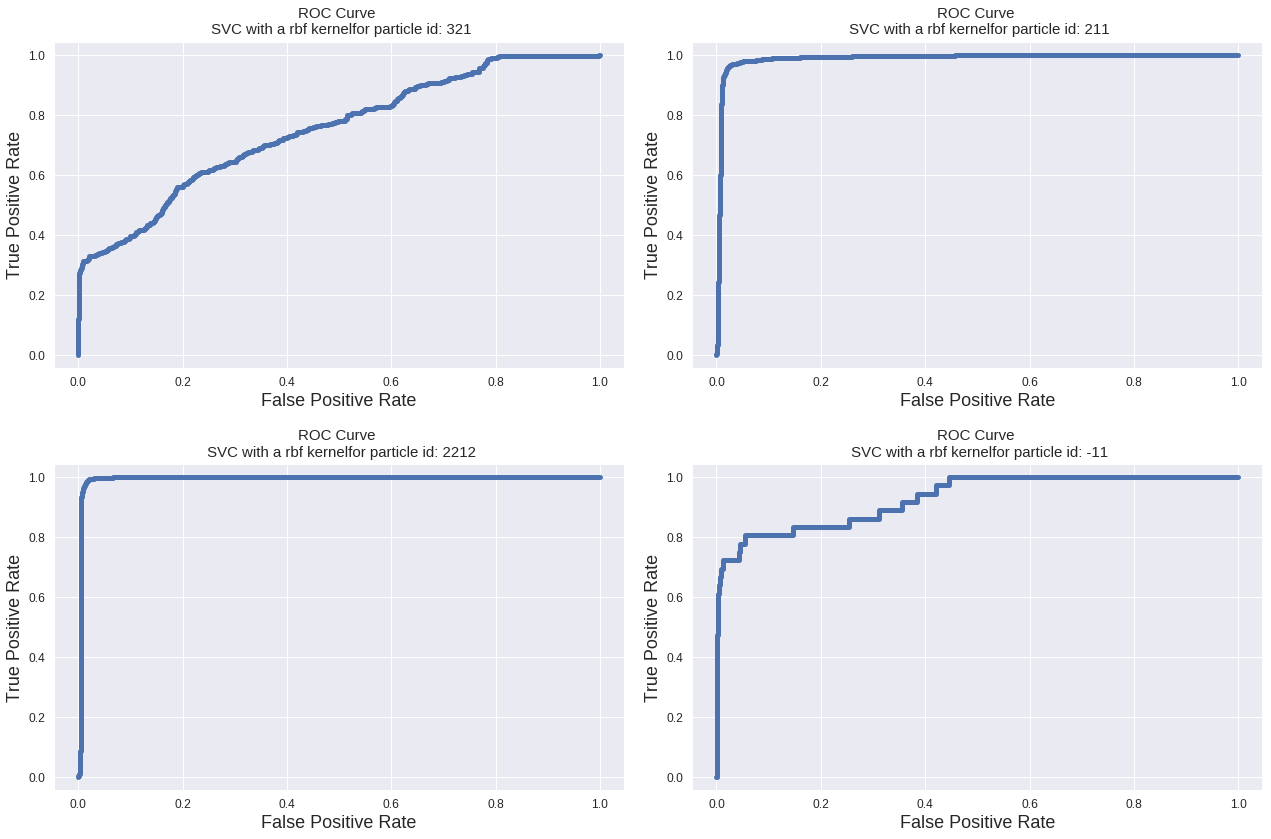

In [95]:
plt_title = 'ROC Curve \n SVC with a rbf kernel'
x_label = 'False Positive Rate'
y_label = 'True Positive Rate'


fig = plt.figure(figsize=(18,12))

for pos_label in [0,1,2,3]:
  fpr, tpr, thrsld_list = roc_curve(m_Y, m_decision_values[pos_label], pos_label=pos_label )
  ax = fig.add_subplot(2,2,pos_label+1,xlabel=x_label, ylabel = y_label, title = plt_title+'for particle id: {}'.format(targets[pos_label])  )
  ax.plot(fpr, tpr)
  

plt.tight_layout()  
plt.show()